C:\Users\bgpa4\AppData\Local\Temp\ipykernel_20080\1579461794.py:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


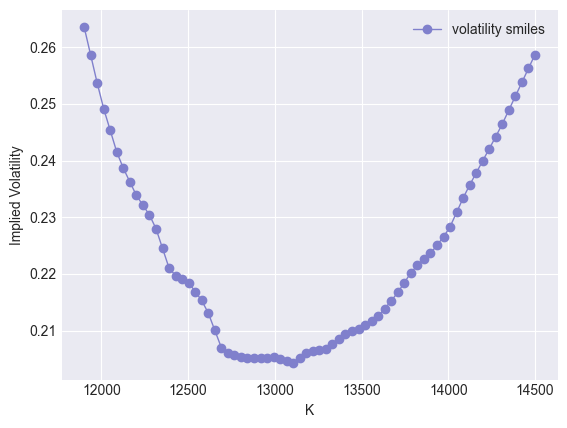

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def Slope(X, Y, axis=1):
    sorted_idx = np.argsort(X, axis=axis)
    X = np.take_along_axis(X, sorted_idx, axis=axis)
    Y = np.take_along_axis(Y, sorted_idx, axis=axis)
    if axis==1:
        delta_X = X[:,1:] - X[:,:-1]
        delta_Y = Y[:,1:] - Y[:,:-1]
    if axis==0:
        delta_X = X[1:] - X[:-1]
        delta_Y = Y[1:] - Y[:-1]
    return delta_Y / delta_X

def recovery_curve(x, slope, y0=0.5):
    delta_x = x[1:] - x[:-1]
    delta_y = delta_x*slope
    y = np.array([delta_y[:i].sum() for i in range(1, len(x), 1)]) + y0
    y = np.hstack((np.array([y0]), y))
    return y
closing_or_settlement = '結算價' 


IV_data = pd.read_csv('./../../Data/Organized/all/InterpolateData_samemetric(call).csv', \
                    encoding='Big5', index_col=False)

IV_matrix = np.array(IV_data)
K_num = len(np.where(IV_matrix[0,0] == IV_matrix)[0])
K = np.array(IV_data['履約價({})'.format(closing_or_settlement)])
K = np.reshape(K, (-1, K_num))
IV = np.array(IV_data['隱含波動率({})'.format(closing_or_settlement)])
IV= np.reshape(IV, (-1, K_num))
K_IVslope= Slope(X=K, Y=IV, axis=1)



k = 2000
plt.style.use('seaborn-darkgrid')
plt.plot(K[k], IV[k], lw=1, ls='-', marker='o', c=[0.5, 0.5, 0.8], label='volatility smiles')
#plt.plot([Udata[k,4]]*2, [Kmin, Kmax], lw=1, ls='--', c=[0.8, 0.5, 0.5], label='futures price')
plt.xlabel('K')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

若$X=[x_1, x_2,\dots x_n     ]$  
則 $TimeSeriesData(X, 30)= [[x_1, x_2,\dots x_{30}],\quad [x_2, x_3,\dots x_{31}]\dots [x_{n-30}, x_{n-29},\dots x_{n-1}]],\quad [x_{31}, x_{32},\dots x_n     ]$  

In [98]:
def TimeSeriesData(X, seq_length):
    X_ = np.zeros((len(X)-seq_length, seq_length, len(X[0])))
    y_ = np.zeros((len(X)-seq_length, len(X[0])))
    for i in range(len(X) - seq_length):
        X_[i] = X[i:i+seq_length]
        y_[i] = (X[i+seq_length])
    return np.array(X_), np.array(y_)
seq_length = 3
magnification_slope = 10000
IV_matrix_forecast = IV_matrix[seq_length*K_num:]
#收盤價
Inputs_slope, Ouputs = TimeSeriesData(K_IVslope*magnification_slope, seq_length=seq_length)
columns_names_OHLC = ['期貨開盤價', '期貨最高價', '期貨最低價', '期貨收盤價']
column_index_OHLC = [IV_data.columns.get_loc(col) for col in columns_names_OHLC]
Inputs_OHLC = IV_matrix[range(0, len(IV_matrix), K_num)]
Inputs_OHLC = Inputs_OHLC[:,column_index_OHLC]
Inputs_OHLC = np.array([Inputs_OHLC[i:i+seq_length+1] for i in range(len(Inputs_OHLC)-seq_length)])
Inputs_OHLC = Inputs_OHLC.astype(float)

train_size = int(len(Inputs_slope)*0.8)
Slope_train = Inputs_slope[:train_size]
OHLC_train = Inputs_OHLC[:train_size]
y_train = Ouputs[:train_size]
Slope_test = Inputs_slope[train_size:]
y_test = Ouputs[train_size:]
IV_matrix_test = IV_matrix_forecast[K_num*train_size:]
OHLC_test = Inputs_OHLC[train_size:]


In [127]:
layers_num = np.random.choice(range(1, 5, 1), (3,2))
layers_num[:,1] = layers_num[:,1] - 1
print(layers_num)

neurons_num_OHLC = np.random.choice(range(200, 1001, 1), (layers_num[0].sum()))
neurons_num_slope = np.random.choice(range(200, 1001, 1), (layers_num[1].sum()))
neurons_num_megred = np.random.choice(range(200, 1001, 1), (layers_num[2,0]))
print(layers_num.sum(axis=1))
print(neurons_num_OHLC)
print(neurons_num_slope)
print(neurons_num_megred)


[[4 3]
 [1 0]
 [4 3]]
[7 1 7]
[347 205 319 539 767 906 649]
[238]
[949 991 450 545]


In [176]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate
from io import StringIO
layers_num = np.random.choice(range(1, 5, 1), (3,2))
layers_num[:,1] = layers_num[:,1] - 1
print(layers_num)

neurons_num_OHLC = np.random.choice(range(200, 1001, 1), (layers_num[0].sum()))
neurons_num_slope = np.random.choice(range(200, 1001, 1), (layers_num[1].sum()))
neurons_num_megred = np.random.choice(range(200, 1001, 1), (layers_num[2,0]))
#print(layers_num.sum(axis=1))
print(neurons_num_OHLC)
print(neurons_num_slope)
print(neurons_num_megred)

input_lstm_OHLC = Input(shape=OHLC_train.shape[1:])
Hidden_OHLC = np.array([object] * layers_num[0].sum())
Hidden_OHLC[0:layers_num[0, 0]] = np.array([LSTM(neurons_num_OHLC[i], return_sequences=True \
            , activation='relu') if i < layers_num[0, 0]-1 else LSTM(neurons_num_OHLC[i], \
            activation = 'relu') for i in range(layers_num[0, 0])])
Hidden_OHLC[layers_num[0, 0]:] = np.array([Dense(neurons_num_OHLC[i], activation='relu') \
                                           for i in range(layers_num[0,0], layers_num[0].sum(), 1)])
output_OHLC = Hidden_OHLC[0](input_lstm_OHLC)
for i in range(1, layers_num[0].sum(), 1):
    output_OHLC = Hidden_OHLC[i](output_OHLC)

input_lstm_slope = Input(shape=Slope_train.shape[1:])
Hidden_slope = np.array([object] * layers_num[1].sum())
Hidden_slope[0:layers_num[1, 0]-1] = np.array([LSTM(neurons_num_slope[i], return_sequences=True\
            , activation='relu')  for i in range(layers_num[1, 0]-1)])
Hidden_slope[layers_num[1, 0]-1] = LSTM(neurons_num_slope[layers_num[1, 0]-1])
Hidden_slope[layers_num[1, 0]:] = np.array([Dense(neurons_num_slope[i], activation='relu')\
                                        for i in range(layers_num[1, 0], layers_num[1].sum(), 1)])
output_slope = Hidden_slope[0](input_lstm_slope)
for i in range(1, layers_num[1].sum(), 1):
    output_slope = Hidden_slope[i](output_slope)
       
megred = concatenate([output_OHLC, output_slope], axis=-1)
Hidden_megred = np.array([object]*layers_num[2, 0])
Hidden_megred[:-1] = np.array([Dense(neurons_num_megred[i], activation='relu') \
                               for i in range(layers_num[2, 0]-1)])
Hidden_megred[-1] = Dense(neurons_num_megred[-1])
output = Hidden_megred[0](megred)
for i in range(1, layers_num[2, 0], 1):
    output = Hidden_megred[i](output)
output = Dense(y_train.shape[1])(output)
model = Model([input_lstm_OHLC, input_lstm_slope], outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()




[[4 3]
 [4 1]
 [3 0]]
[274 461 439 707 695 750 473]
[437 885 635 770 746]
[233 585 360]
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_50 (InputLayer)       [(None, 4, 4)]               0         []                            
                                                                                                  
 lstm_96 (LSTM)              (None, 4, 274)               305784    ['input_50[0][0]']            
                                                                                                  
 lstm_97 (LSTM)              (None, 4, 461)               1357184   ['lstm_96[0][0]']             
                                                                                                  
 input_51 (InputLayer)       [(None, 3, 69)]              0         []                            
   

In [20]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate

input_lstm_OHLC = Input(shape=OHLC_train.shape[1:])
Hidden_OHLC = [LSTM(1000, return_sequences=True, activation='relu'),
               LSTM(100, activation='relu'),
               Dense(1000)]
for i in range(len(Hidden_OHLC)):
    if i == 0:
        output_OHLC = Hidden_OHLC[i](input_lstm_OHLC)
    else:
        output_OHLC = Hidden_OHLC[i](output_OHLC)
input_lstm_slope = Input(shape=Slope_train.shape[1:])
Hidden_slope = [LSTM(1000, activation='relu'),
               Dense(1000)]
for i in range(len(Hidden_slope)):
    if i == 0:
        output_slope = Hidden_slope[i](input_lstm_slope)
    else:
        output_slope = Hidden_slope[i](output_slope)

megred = concatenate([output_OHLC, output_slope], axis=-1)
Hidden_megred = [Dense(500, activation = 'relu'),
                 Dense(200, activation = 'relu')]
for i in range(len(Hidden_megred)):
    if i == 0:
        output = Hidden_megred[i](megred)
    else:
        output = Hidden_megred[i](output)
model = Model([input_lstm_OHLC, input_lstm_slope], outputs = output)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 4, 4)]               0         []                            
                                                                                                  
 lstm_19 (LSTM)              (None, 4, 1000)              4020000   ['input_13[0][0]']            
                                                                                                  
 input_14 (InputLayer)       [(None, 3, 69)]              0         []                            
                                                                                                  
 lstm_20 (LSTM)              (None, 100)                  440400    ['lstm_19[0][0]']             
                                                                                            

In [9]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, concatenate
from keras.optimizers import Adam

# 定義第一個ANN模型
input_lstm_OHLC = Input(shape=OHLC_train.shape[1:])
hidden1_OHLC = LSTM(1000, return_sequences=True, activation='relu')(input_lstm_OHLC)
hidden2_OHLC = LSTM(100, activation='relu')(hidden1_OHLC)
output_OHLC = Dense(1000)(hidden2_OHLC)

# 定義第二個LSTM模型
input_lstm_slope = Input(shape=Slope_train.shape[1:])
#lstm1 = LSTM(200, return_sequences=True, activation='relu')(input_slope)
hidden1_slope = LSTM(1000, activation='relu')(input_lstm_slope)
output_slope = Dense(1000)(hidden1_slope)

# 合併兩個模型的輸出
#merged = concatenate([output_ann, dense_lstm], axis=-1)
merged = concatenate([output_OHLC, output_slope], axis=-1)

# 加入一個Dense層
dense1 = Dense(500, activation='relu')(merged)
dense2 = Dense(200, activation='relu')(dense1)
# 最終輸出層
output = Dense(y_train.shape[1])(dense2)

# 定義模型
model = Model(inputs=[input_lstm_OHLC, input_lstm_slope], outputs=output)

# 編譯模型
#adam = Adam(learning_rate=0.1)
adam = Adam()
model.compile(loss='mse', optimizer = 'adam', metrics=['mse'])

# 顯示模型結構
#model.summary()



# 訓練模型
model.fit([OHLC_train, Slope_train], y_train, epochs=50, \
          batch_size=3000, validation_split=0.2)

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 14262.8818 - mse: 14262.8818 - val_loss: 3233.1030 - val_mse: 3233.1030
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 1489.8900 - mse: 1489.8900 - val_loss: 2770.6340 - val_mse: 2770.6340
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 1221.0189 - mse: 1221.0189 - val_loss: 457.6801 - val_mse: 457.6801
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 216.5161 - mse: 216.5161 - val_loss: 371.3130 - val_mse: 371.3130
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 180.5892 - mse: 180.5892 - val_loss: 114.3411 - val_mse: 114.3411
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 60.2239 - mse: 60.2239 - val_loss: 111.8926 - val_mse: 111.8926
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 60.2264 - mse: 60.2264 - val_loss: 101.5398 - val_mse: 101.5398
Epoch 8/50
1/1 [==============================]

In [10]:
model.fit([OHLC_train, Slope_train], y_train, epochs=20, batch_size=3000, validation_split=0.2)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 10.5904 - mse: 10.5904 - val_loss: 5.8060 - val_mse: 5.8060
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 10.5967 - mse: 10.5967 - val_loss: 561.2458 - val_mse: 561.2458
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 164.9325 - mse: 164.9325 - val_loss: 6.6993 - val_mse: 6.6993
Epoch 4/20
1/1 [==============================] - 3s 3s/step - loss: 10.6571 - mse: 10.6571 - val_loss: 5.8402 - val_mse: 5.8402
Epoch 5/20
1/1 [==============================] - 3s 3s/step - loss: 10.6487 - mse: 10.6487 - val_loss: 6.6361 - val_mse: 6.6361
Epoch 6/20
1/1 [==============================] - 3s 3s/step - loss: 12.1170 - mse: 12.1170 - val_loss: 5.8343 - val_mse: 5.8343
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 10.6483 - mse: 10.6483 - val_loss: 5.8801 - val_mse: 5.8801
Epoch 8/20
1/1 [==============================] - 3s 3s/step - loss: 10.7121 - mse: 10.7121

In [10]:
test_loss = model.evaluate([OHLC_test, Slope_test], y_test)
print("Test Loss:", test_loss)

# 查看測試輸出
y_pred = model.predict([OHLC_test, Slope_test])



18/18 [==============================] - 0s 19ms/step - loss: 1.4934 - mse: 1.4934
Test Loss: [1.493403673171997, 1.493403673171997]
18/18 [==============================] - 1s 20ms/step


In [11]:
columns_names_K = '履約價({})'.format(closing_or_settlement)
column_index_K = IV_data.columns.get_loc(columns_names_K) 
ForecastIV = np.zeros(((len(y_pred), K_num)))
for i in range(len(y_pred)):
    x = IV_matrix_test[i*K_num:(i+1)*K_num, column_index_K]
    v0 = IV_matrix_test[i*K_num,8]
    ForecastIV[i] = recovery_curve(x, y_pred[i]/(magnification_slope), y0=v0)
ForecastIV = np.reshape(ForecastIV,(-1,1))
Forecast_matrix  = np.hstack((IV_matrix_test, ForecastIV))
column = np.hstack((IV_data.columns.to_numpy(), np.array(['預測隱含波動率({})'.format(closing_or_settlement)])))
Forecast_Data = pd.DataFrame(data=Forecast_matrix, columns=column)
Forecast_Data.to_csv('./../../Data/forecast/ForecastIV_02.csv', index=False, encoding='Big5')